In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bin import utils

In [2]:
cdata_bin20 = sc.read_h5ad("./RNA/spatial.combined.bin20.h5")
cdata_bin100 = sc.read_h5ad("./RNA/spatial.combined.bin100.h5")

In [3]:
def extract_guide_from_rna(cdata):
    sg_genes = cdata.var_names[cdata.var_names.str.startswith("sg")]
    rna_genes = cdata.var_names[~cdata.var_names.str.startswith("sg")]
    guidedata = cdata[:, sg_genes]
    rnadata = cdata[:, rna_genes]
    return rnadata, guidedata

In [11]:
cdata_bin20 = utils.remove_mito_ribo_hk_lnc_genes(cdata_bin20)
sc.pp.filter_cells(cdata_bin20, min_counts=3)
sc.pp.filter_cells(cdata_bin20, min_counts=3)
cdata_bin100 = utils.remove_mito_ribo_hk_lnc_genes(cdata_bin100)
sc.pp.filter_cells(cdata_bin100, min_counts=3)
sc.pp.filter_cells(cdata_bin100, min_counts=3)
rnadata_bin20, guidedata_bin20 = extract_guide_from_rna(cdata_bin20)
rnadata_bin100, guidedata_bin100 = extract_guide_from_rna(cdata_bin100)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [35]:
r_dict = {}
r_dict_ = {}
guide_genes = guidedata_bin20.var_names.str.split('_').str.get(0).unique()
for guide in tqdm(guide_genes):
    if guide+"_1" in guidedata_bin20.var_names and guide+"_2" in guidedata_bin20.var_names:
        r_dict[guide] = spearmanr(guidedata_bin20[:, guide + "_1"].X.toarray(), guidedata_bin20[:, guide + "_2"].X.toarray())[0]
        r_dict_[guide] = pearsonr(guidedata_bin20[:, guide + "_1"].X.toarray().flatten(), guidedata_bin20[:, guide + "_2"].X.toarray().flatten())[0]
    else: r_dict[guide] = 0

100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


In [38]:
df = pd.concat([pd.DataFrame(r_dict, index=['spearmanr']), pd.DataFrame(r_dict_, index=['pearsonr'])], axis=0).T

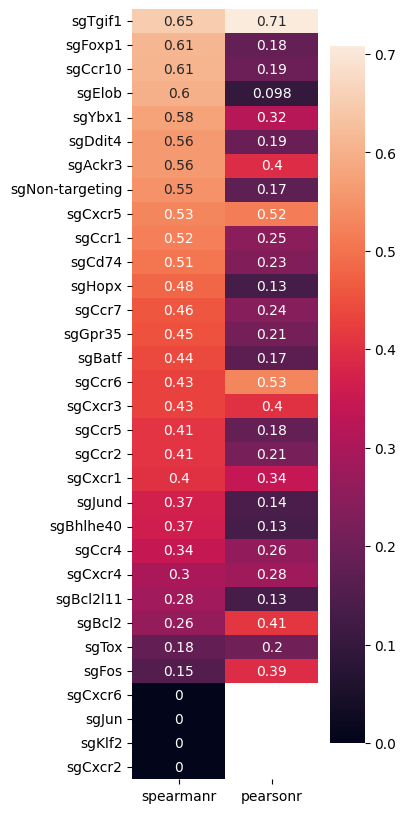

In [55]:
import seaborn as sns
plt.figure(figsize=(3, 10))
sns.heatmap(df.sort_values(by='spearmanr', ascending=False), annot=True)
plt.show()

In [46]:
guidedata_bin20 = utils.combine_guide_replicates(guidedata_bin20)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [48]:
guide_corr_matrix = np.zeros((len(guide_genes), len(guide_genes)))
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from tqdm import tqdm
for i, guide in tqdm(enumerate(guide_genes)):
    for j, guide_x in enumerate(guide_genes):
        common_bins = guidedata_bin20[(guidedata_bin20[:, guide].X > 0) | (guidedata_bin20[:, guide_x].X > 0)]
        guide_corr_matrix[i, j] = spearmanr(common_bins[:, guide].X.toarray(), common_bins[:, guide_x].X.toarray())[0]

32it [00:13,  2.45it/s]


In [49]:
guide_corr_matrix

array([[1.        , 0.31611216, 0.27986811, ..., 0.41873795, 0.31010377,
        0.41331137],
       [0.31611216, 1.        , 0.24909778, ..., 0.41150225, 0.31422001,
        0.43156609],
       [0.27986811, 0.24909778, 1.        , ..., 0.38674566, 0.23220566,
        0.33828761],
       ...,
       [0.41873795, 0.41150225, 0.38674566, ..., 1.        , 0.29381949,
        0.47161488],
       [0.31010377, 0.31422001, 0.23220566, ..., 0.29381949, 1.        ,
        0.25880157],
       [0.41331137, 0.43156609, 0.33828761, ..., 0.47161488, 0.25880157,
        1.        ]])

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


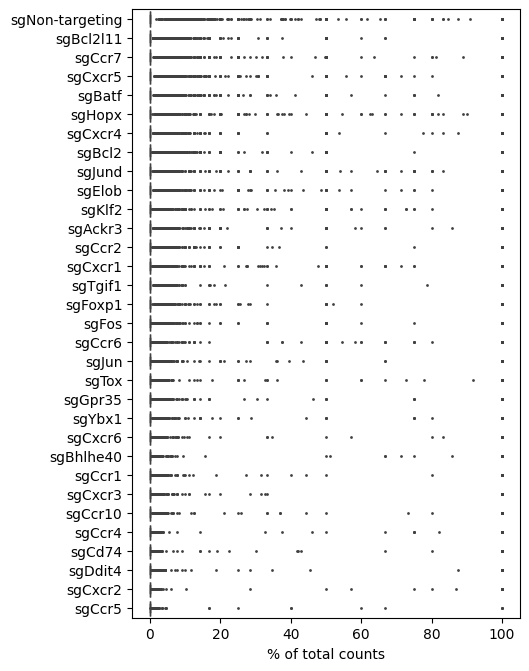

In [50]:
sc.pl.highest_expr_genes(guidedata_bin20, n_top=32)

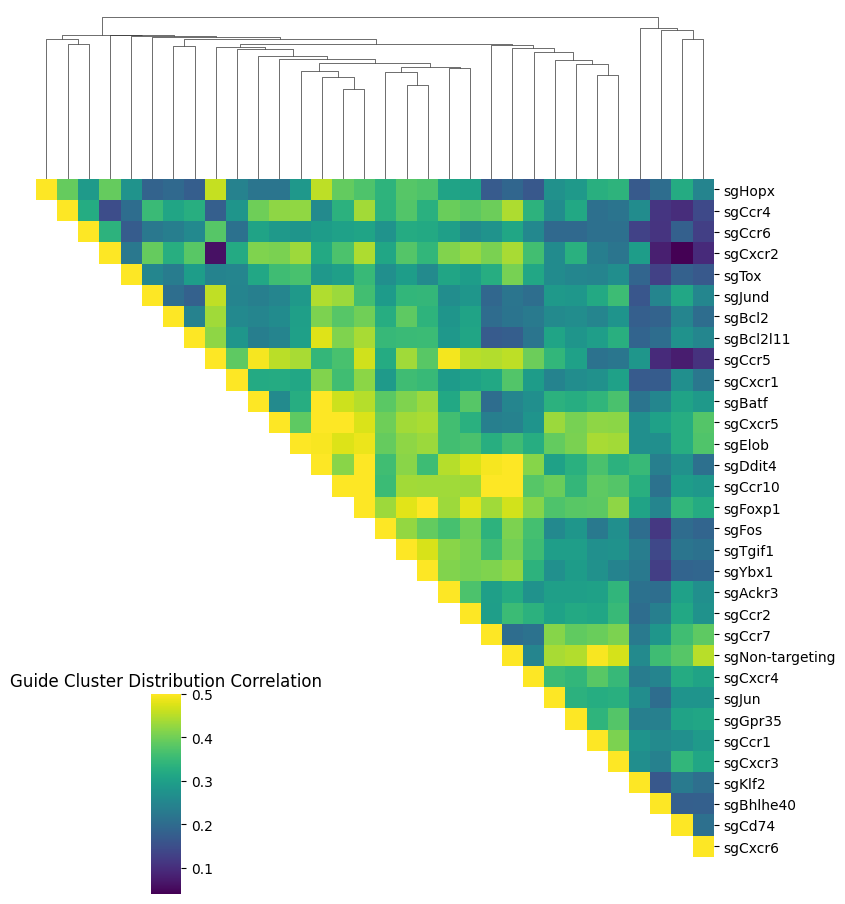

In [54]:
guide_corr_df = pd.DataFrame(guide_corr_matrix, columns=guide_genes, index=guide_genes)

# 使用 seaborn 的 clustermap 绘制热图，并只对 x 轴进行聚类
g = sns.clustermap(guide_corr_df, cmap='viridis', figsize=(10, 10), col_cluster=True, row_cluster=True, vmax=0.5)

# 只显示右上角部分的矩阵，并保留颜色条
g.ax_row_dendrogram.set_visible(False)

# 获取聚类后的索引顺序
clustered_index = g.dendrogram_row.reordered_ind
clustered_columns = g.dendrogram_col.reordered_ind

# 创建一个新的掩码，只显示右上角部分
mask = np.zeros_like(guide_corr_df, dtype=bool)
mask[np.tril_indices_from(mask, -1)] = True

for i in range(len(mask)):
    for j in range(len(mask)):
        if mask[clustered_index[i], clustered_columns[j]]:
            g.ax_heatmap.add_patch(plt.Rectangle((clustered_columns[j], clustered_index[i]), 1, 1, fill=True, color='white', lw=0))

g.ax_heatmap.xaxis.tick_top()
g.ax_heatmap.xaxis.set_label_position('top')

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks(np.arange(len(guide_corr_df.index)) + 0.5)
g.ax_heatmap.set_yticklabels(guide_corr_df.index[clustered_index])

cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.set_position([0.3, 0.1, 0.03, 0.2])  # [left, bottom, width, height]

plt.title('Guide Cluster Distribution Correlation')

plt.show()

# subtype proportion

In [59]:
np.quantile(guidedata_bin100.X.toarray(), 0.999)

6.0

In [61]:
guidedata_bin100 = utils.combine_guide_replicates(guidedata_bin100)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [62]:
major_clone = {}
for guide in guidedata_bin100.var_names:
    major_clone[guide] = guidedata_bin100[guidedata_bin100[:, guide].X > 6]

/tmp/ipykernel_50299/1300133697.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


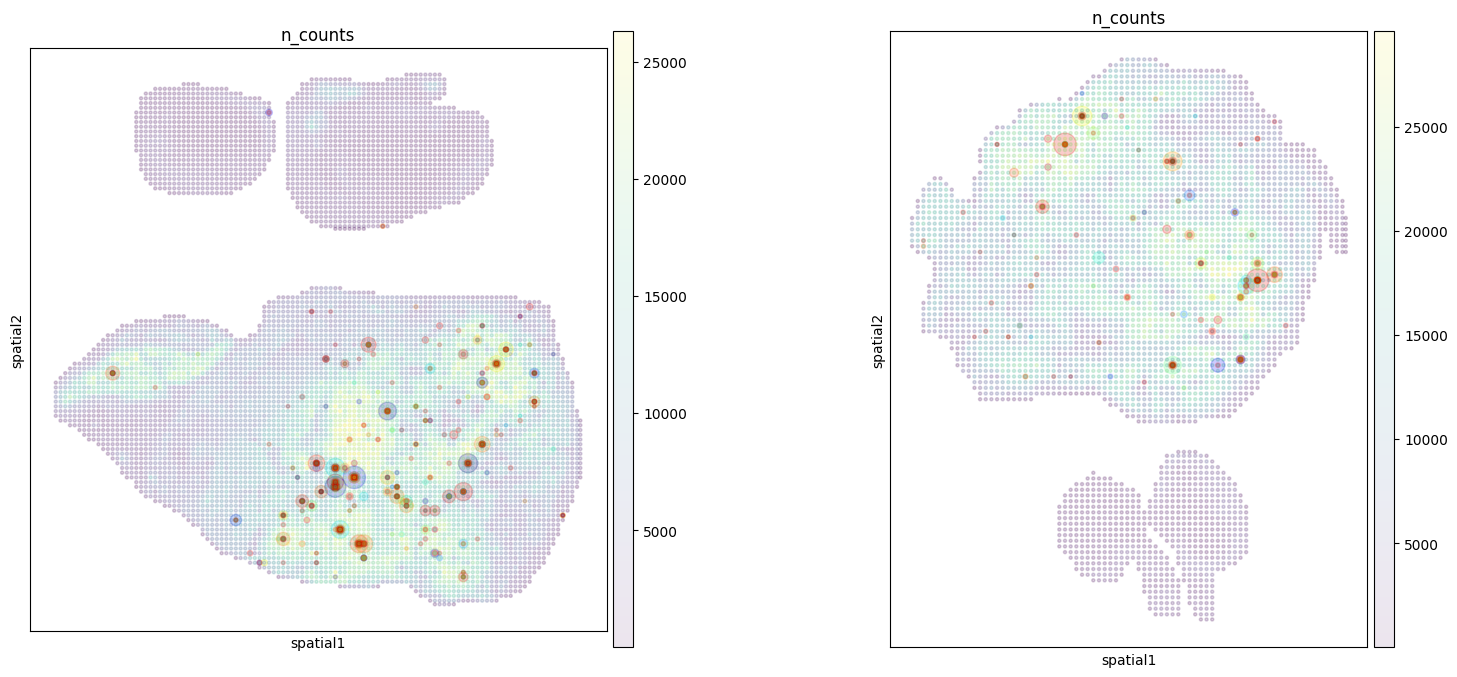

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
import matplotlib.cm as cm
colormap = cm.get_cmap("jet")
colors = colormap(np.linspace(0, 1, len(major_clone.keys())))
for idx, guide in enumerate(major_clone):
    utils.plot_dot(major_clone[guide][major_clone[guide].obs["marker"] == 'A'], ax=ax[0], gene_name=guide, square=False, color=colors[idx])
    utils.plot_dot(major_clone[guide][major_clone[guide].obs["marker"] == 'B'], ax=ax[1], gene_name=guide, square=False, color=colors[idx])
sq.pl.spatial_scatter(
    rnadata_bin100,
    color=['n_counts'],
    library_key='marker',  
    size=20,
    spatial_key='spatial',
    cmap='viridis',
    shape=None,
    ax=ax,
    fig=fig,
    alpha=0.1
)

In [71]:
annotation = sc.read_h5ad("./RNA/spatial.combined.annotation.h5")

In [74]:
annotation

AnnData object with n_obs × n_vars = 278122 × 13864
    obs: 'marker', 'annotations'
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    uns: 'rank_genes_groups'
    obsm: 'spatial'

In [92]:
c_df = pd.DataFrame(columns=["Unknown T", "memory T", "effector T", "stem-like T", "exhausted T"])
for guide in tqdm(major_clone):
    major_clone_annot = utils.extract_small_bin(annotation, major_clone[guide])
    df = pd.DataFrame(major_clone_annot.obs["annotations"].value_counts()).T
    df = df.loc[:, df.columns.str.endswith('T')]
    c_df = pd.concat([df, c_df])

  3%|▎         | 1/32 [00:00<00:03,  8.38it/s]/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:305: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bin100_masked_data.obs["spatial_cov"] = ['_'.join(map(str, [array[0] // bin_size * bin_size, array[1] // bin_size * bin_size])) for array in bin100_masked_data.obsm["spatial"]]
  6%|▋         | 2/32 [00:00<00:10,  2.85it/s]/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:305: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bin100_masked_data.obs["spatial_cov"] = ['_'.join(map(str, [array[0] // bin_size * bin_size, array[1] // bin_size * bin_size])) for array in bin100_masked_data.obsm["spatial"]]
  9%|▉         | 3/32 [00:01<00:12,  2.41it/s]/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:305: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bin100_masked_data.obs["spat

In [94]:
c_df.fillna(0, inplace=True)
c_df.index = major_clone.keys()

/tmp/ipykernel_50299/893254889.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  c_df.fillna(0, inplace=True)


In [95]:
c_df

,Unknown T,memory T,effector T,stem-like T,exhausted T
sgAckr3,17,6,5,1,1
sgBatf,4,3,4,2,0
sgBcl2,18,9,8,2,1
sgBcl2l11,80,47,33,7,5
sgBhlhe40,11,9,5,2,1
sgCcr1,14,15,9,3,0
sgCcr10,6,5,4,2,0
sgCcr2,26,8,13,3,1
sgCcr4,7,10,6,2,0
sgCcr5,15,9,9,3,1


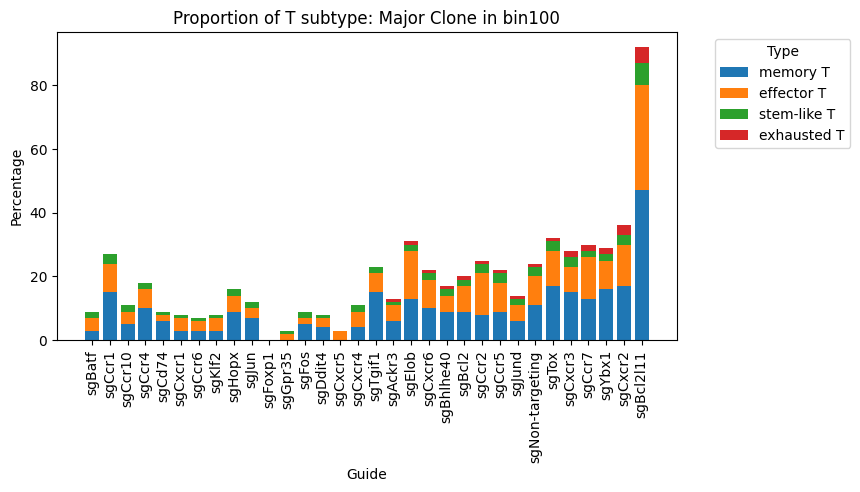

In [107]:
t_df = c_df.iloc[:, 1:]
#guide_percentage = t_df.div(t_df.sum(axis=1), axis=0) * 100
guide_percentage = t_df
guide_percentage.sort_values(by="exhausted T", inplace=True)

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(guide_percentage))

for column in guide_percentage.columns:
    plt.bar(guide_percentage.index, guide_percentage[column], bottom=bottom, label=column)
    bottom += guide_percentage[column]

plt.xlabel('Guide')
plt.ylabel('Percentage')
plt.title('Proportion of T subtype: Major Clone in bin100')
plt.xticks(rotation=90)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()